In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
DAY=16

In [3]:
dim=(54, 4100, 1704)
def get_series(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b
def get_series2(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==(4100, 54, 1704)
    return b  
def s_lag(arr,lag=1):
    l,m,n=arr.shape
    assert lag>0 and lag<n
    a=arr[:,:,:-lag]
    b=np.empty(shape=[l,m,lag],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([b,a],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba    

In [4]:
cat_lag_features={
 "city_0",
  "class_0",
  "cluster_0",
  "family_0",
  "state_0",
  "type_0",

 'city_mv36',
 'class_mv36',
 'cluster_mv36',
 'family_mv36',
 'state_mv36',
 'type_mv36',    
 
 'item_mean_0',
 'store_mean_0',
 }
cat_features={
 'holiday_0',
 'onpromotion_0',
 'wage_0',
 'd900'
 }
oil_features={'oil_0', 'oil_d1', 'oil_d10', 'oil_d15', 'oil_d3', 'oil_d5'}
sales_ma_features={'sales_ma_112',
 'sales_ma_14',
 'sales_ma_224',
 'sales_ma_28',
 'sales_ma_3',
 'sales_ma_56',
 'sales_ma_7'}
sales_season_ma_features={'sales_week_season_ma_p13',
 'sales_week_season_ma_p2',
 'sales_week_season_ma_p3',
 'sales_week_season_ma_p4',
 'sales_week_season_ma_p7'}

#move x, fix y
def _get_feature(name,lag=0,offset=0):
    if name in cat_lag_features :
        assert lag == 0
        if name in ['item_mean_0','class_mv36','family_mv36','class_0','family_0']:
            s=get_series2(name)
        else:
            s=get_series(name)
        return s_lag(s,offset)
    if name in cat_features or name in oil_features:
        assert offset==0 and lag==0
        s= get_series(name)
        if name =='holiday_0': s[np.isnan(s)]=0
        return s
    if name =="y_0" or name in sales_ma_features or name in sales_season_ma_features:
        #assert  lag == 0
        s=get_series(name)
        if offset==0 and lag==0: return s
        return s_lag(s,lag=offset+lag)
def get_feature(name,lag=0,offset=0):
    s=_get_feature(name=name,lag=lag,offset=offset)
    if s.shape == ( 4100,54, 1704):
        s=np.rollaxis(s,1,0)
    assert s.shape==(54, 4100, 1704), s.shape
    return s
def get_all_features(offset=1):
    assert offset>0
    all_features=[]
    for name in cat_lag_features:
        all_features.append({"name":name,"lag":0,"offset":offset})
    for name in cat_features:
        all_features.append({"name":name,"lag":0,"offset":0})   
#     for name in oil_features:
#         all_features.append({"name":name,"lag":0,"offset":0})  
    for i in range(0,7):
        all_features.append({"name":"y_0","lag":i ,"offset":offset})  
    for name in sales_ma_features:
        all_features.append({"name":name,"lag":0,"offset":offset})  
    for name in sales_season_ma_features:
        all_features.append({"name":name,"lag":(700-offset)%7,"offset":offset})
#     for i in range(1,8):
#         all_features.append({"name":"oil_0","lag":i,"offset":offset})              
    return all_features    
def calc_feature(feat):
    return get_feature(**feat)
def col_name(feat):
    return "{}-lag{}-offset{}".format(feat['name'],feat['lag'],feat['offset'])
def get_train_test(day):
    assert(day>0)
    cols=[]
    train_lst=[]
    
    for feat in get_all_features(day):
        col=col_name(feat)
        print col,
        arr=calc_feature(feat).astype(np.float16)
        train_lst.append(arr)
        cols.append(col)
        gc.collect()
        #break
    return cols,  np.array(train_lst)

In [5]:
def read_data(day):
    print "read data for day", day
    dirname='../input/d'+str(day)+"/"
    y=get_series('y_0')
    cols,train_test=get_train_test(day)
    cols=np.array(cols)    
    print "loaded", y.shape,train_test.shape 
    return cols,train_test,y.astype(np.float16)

In [6]:
%time cols,train_test,y=read_data(DAY)
rawy=y

read data for day 16
store_mean_0-lag0-offset16 family_0-lag0-offset16 city_0-lag0-offset16 cluster_mv36-lag0-offset16 cluster_0-lag0-offset16 city_mv36-lag0-offset16 item_mean_0-lag0-offset16 class_0-lag0-offset16 type_0-lag0-offset16 type_mv36-lag0-offset16 state_mv36-lag0-offset16 class_mv36-lag0-offset16 state_0-lag0-offset16 family_mv36-lag0-offset16 holiday_0-lag0-offset0 d900-lag0-offset0 onpromotion_0-lag0-offset0 wage_0-lag0-offset0 y_0-lag0-offset16 y_0-lag1-offset16 y_0-lag2-offset16 y_0-lag3-offset16 y_0-lag4-offset16 y_0-lag5-offset16 y_0-lag6-offset16 sales_ma_224-lag0-offset16 sales_ma_14-lag0-offset16 sales_ma_28-lag0-offset16 sales_ma_112-lag0-offset16 sales_ma_7-lag0-offset16 sales_ma_3-lag0-offset16 sales_ma_56-lag0-offset16 sales_week_season_ma_p7-lag5-offset16 sales_week_season_ma_p4-lag5-offset16 sales_week_season_ma_p13-lag5-offset16 sales_week_season_ma_p2-lag5-offset16 sales_week_season_ma_p3-lag5-offset16 loaded (54, 4100, 1704) (37, 54, 4100, 1704)
CPU times:

In [7]:
print "types", [u.dtype for u in (cols, train_test, y)]
print "shapes", [u.shape for u in (cols, train_test, y)]
print "mem(gb)",np.round(train_test.nbytes/1024.**3,2), np.round(y.nbytes/1024.**3,2)

types [dtype('S38'), dtype('float16'), dtype('float16')]
shapes [(37,), (37, 54, 4100, 1704), (54, 4100, 1704)]
mem(gb) 26.0 0.7


In [8]:
train_test=np.rollaxis(train_test,0,4)
print "rolled train_test shape", train_test.shape

rolled train_test shape (54, 4100, 1704, 37)


In [9]:
gc.collect()

0

In [10]:
def show_data(store,item,date):
    thisy=y[store,item,date-10:date+10]
    a=train_test[store,item,date-10:date+10,:]
    a=np.squeeze(a)
    print a.shape
    df=pd.DataFrame(a,columns=cols,index=range(date-10,date+10))
    df['target']=thisy
    with pd.option_context('display.max_columns', None):
        display(df)

In [12]:
#show_data(0,1000,1688)

# cv

In [13]:
def make_data(low,high):
    y_train=y[:,:,low:high]
    X_train=train_test[:,:,low:high,:]
    ind=~np.isnan(y_train)
    a,b=X_train[ind],y_train[ind]
    #a=a.astype(np.float32,copy=False)
    #b=b.astype(np.float32,copy=False)
    print a.shape,b.shape,a.dtype,b.dtype
    return a,b 

In [14]:
X,y=make_data(100,1688)

(121371519, 37) (121371519,) float16 float16


In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [16]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [17]:
print K.floatx()

float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.intra_op_parallelism_threads=8
config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [19]:
input_dim=X.shape[1]
input_dim

37

In [20]:
class TransformNALayer(Layer):

    def __init__(self,   **kwargs):
        super(TransformNALayer, self).__init__(**kwargs)
        self.supports_masking = True
    def build(self, input_shape):
        super(TransformNALayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x,training=None):
        def make_na(x):
            ind=tf.is_nan(x)
            filled_x=tf.where(ind, tf.zeros_like(x,dtype=np.float32), x)
            ind=tf.cast(ind,tf.float32)
            filled_x=tf.cast(filled_x,tf.float32)
            return  tf.cast(tf.concat([filled_x,ind],axis=1),tf.float32)
        def add_dropout(x):
            def f(x):
                ind=tf.random_uniform([1,37])<tf.random_uniform([1])[0]/tf.constant(5.0)
                ind2=tf.cast(ind,tf.float32)*tf.ones_like(x)
                newx=tf.where(ind2>0,tf.constant(np.nan,dtype=tf.float32)*tf.ones_like(x), x)
                return newx
            return tf.cond(tf.random_uniform([1])[0]>tf.constant(0.5),lambda: f(x),lambda : x)
        return K.in_train_phase(make_na(add_dropout(x)),make_na(x),training=training)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*2)        

In [21]:
X.shape

(121371519, 37)

In [22]:
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [23]:
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 1.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   print "set learning rate to",lrate
   return lrate
lrate = keras.callbacks.LearningRateScheduler(step_decay)

In [24]:
#plt.plot([step_decay(u) for u in range(5)])

In [25]:
class KerasModel:
    def __init__(self,params={}):
        self.params=params
        self.model=None
    def _make_model(self):
        params=self.params
        model = Sequential()
        model.add(InputLayer(input_shape=params['input_dim']))
        model.add(TransformNALayer())
        for sz in params["hidden_layer_sizes"]:
            if params['batch_normalization']:
                model.add(BatchNormalization())
            model.add(Dense(sz,kernel_regularizer=regularizers.l2(params['l2'])))
            model.add(Dropout(params['dropout_rate']))            
            model.add(Activation(params['activation']))
        if params['loss'] == 'mean_squared_error':
            model.add(Dense(1,activation=None))
            this_loss="mean_squared_error"
            if params['metric']=="mean_squared_error":
                this_metrics=['mean_squared_error']
            else:
                raise Exception("unknown")
        else:
            raise Exception("unknown")
        model.compile(optimizer=params['optimizer'],
          loss=this_loss,
                      metrics=None)
          #metrics=this_metrics)

        self.model=model
        return self
    def fit(self,X,y):
        params=self.params
        validation_split=params['validation_split']
        patience=params['patience']
        if self.model is None:
            self._make_model()
        metric_name=self.model.metrics_names[-1]
        #print "earlystopping on "+metric_name
        #self.name='day'+str(DAY)+'_adam.{epoch:02d}-{val_loss:.3f}.h5'
        self.name='day'+str(DAY)+'_adam.h5'
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        checkpoint = keras.callbacks.ModelCheckpoint(self.name, monitor='val_loss', 
                                                     verbose=1, 
                                                     save_best_only=True, 
                                                     save_weights_only=False, 
                                                     mode='auto', period=1)        
        batch_size=params['batch_size']
        self.hist=self.model.fit(X, y, batch_size=batch_size,epochs=200, 
                       validation_split=validation_split, 
                       #validation_data=(X_valid,y_valid),
                       callbacks=[early_stopping,checkpoint],verbose=1)
        return self
    def load_best(self):
        return keras.models.load_model(self.name,
                                       custom_objects={'TransformNALayer':TransformNALayer})
    

In [26]:
param_grid={'input_dim':[(input_dim,)],
            'batch_size':[1024],
            'hidden_layer_sizes': [(256,256),()],
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "validation_split":[0.1],"patience":[3],
            "dropout_rate":[0.0],
            "activation":['relu'],    
            "l2":[1e-6,0],
            "epsilon":[0.1],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
len(parameters)

12

In [27]:
parameter=parameters[0]
parameter

{'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 1024,
 'dropout_rate': 0.0,
 'epsilon': 0.1,
 'hidden_layer_sizes': (256, 256),
 'input_dim': (37,),
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3,
 'validation_split': 0.1}

In [28]:
def run_once(parameter):
    backend.clear_session()
    set_session(tf.Session(config=config))
    a=KerasModel(parameter)
    a._make_model()
    h=a.fit(X,y)
    return [parameter,h.history]

In [29]:
if 0:
    backend.clear_session()
    set_session(tf.Session(config=config))    
    a=KerasModel(parameter)
    a._make_model()
    from IPython.display import SVG
    from keras.utils.vis_utils import model_to_dot
    for l in a.model.layers:
        print l, l.input_shape 
    display(SVG(model_to_dot(a.model).create(prog='dot', format='svg')))
   

In [30]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=KerasModel(parameter)
a._make_model()

<__main__.KerasModel instance at 0x7fdbc84e1f80>

In [31]:
a.params

{'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 1024,
 'dropout_rate': 0.0,
 'epsilon': 0.1,
 'hidden_layer_sizes': (256, 256),
 'input_dim': (37,),
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3,
 'validation_split': 0.1}

In [32]:
a.fit(X,y)

Train on 109234367 samples, validate on 12137152 samples
Epoch 1/200
109234367/109234367 [==============================] - 820s 8us/step - loss: 0.2910 - val_loss: 0.2934
Epoch 2/200
109234367/109234367 [==============================] - 822s 8us/step - loss: 0.2873 - val_loss: 0.2939
Epoch 3/200
109234367/109234367 [==============================] - 816s 7us/step - loss: 0.2867 - val_loss: 0.2951
Epoch 4/200
109234367/109234367 [==============================] - 815s 7us/step - loss: 0.2865 - val_loss: 0.2958


<__main__.KerasModel instance at 0x7fdbc84e1f80>

In [33]:
XX=X[-1000000:]
yy=y[-1000000:]

In [34]:
from sklearn.metrics import mean_squared_error
amodel=a.model
yy_pred1=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred1)

0.28386039

In [35]:
from sklearn.metrics import mean_squared_error
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
yy_pred1=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred1)

0.28296837

In [36]:
train_test.shape

(54, 4100, 1704, 37)

In [37]:
from sklearn.metrics import mean_squared_error
lst=[]
lst2=[]
lst3=[]
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in range(1500,1688):
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    ay=rawy[:,:,i].reshape(-1)
    yy_pred3=amodel.predict(ax,4096)[:,0]
    lst.append(yy_pred3.reshape(rawy.shape[:2]))
    lst2.append(~np.isnan(rawy[:,:,i]))
    lst3.append(rawy[:,:,i])
    print i,mean_squared_error(ay[~np.isnan(ay)],yy_pred3[~np.isnan(ay)])

1500 0.275607
1501 0.278234
1502 0.271942
1503 0.315325
1504 0.28924
1505 0.296124
1506 0.275386
1507 0.28521
1508 0.284984
1509 0.274136
1510 0.277958
1511 0.275615
1512 0.272657
1513 0.290472
1514 0.28031
1515 0.302568
1516 0.313899
1517 0.33517
1518 0.309555
1519 0.301977
1520 0.294743
1521 0.2914
1522 0.285505
1523 0.296355
1524 0.323604
1525 0.282653
1526 0.276101
1527 0.276384
1528 0.270861
1529 0.285575
1530 0.294026
1531 0.356535
1532 0.279269
1533 0.279971
1534 0.290255
1535 0.296288
1536 0.297309
1537 0.28618
1538 0.310031
1539 0.286692
1540 0.28082
1541 0.291099
1542 0.298627
1543 0.29689
1544 0.284238
1545 0.289979
1546 0.273371
1547 0.278151
1548 0.276024
1549 0.265897
1550 0.274879
1551 0.368281
1552 0.306591
1553 0.326666
1554 0.294343
1555 0.289323
1556 0.277039
1557 0.280986
1558 0.282499
1559 0.315272
1560 0.270648
1561 0.283527
1562 0.301804
1563 0.309131
1564 0.31101
1565 0.288567
1566 0.277664
1567 0.278199
1568 0.284195
1569 0.294377
1570 0.290128
1571 0.292895
15

In [38]:
lst=np.array(lst)
lst2=np.array(lst2)
lst3=np.array(lst3)

In [39]:
import cPickle as pickle
pickle.dump([lst3.astype(np.float16),lst.astype(np.float16)],open(a.name+".info",'wb'))

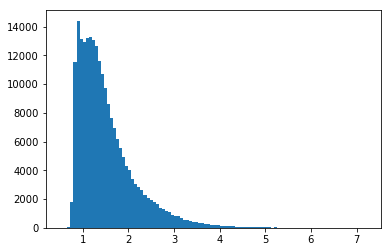

In [40]:
plt.hist(np.array(lst).mean(0).reshape([-1]),bins=100);

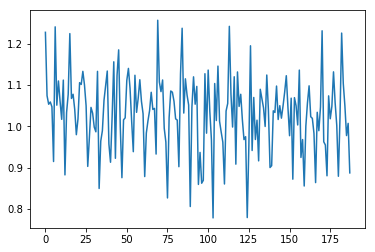

In [41]:
plt.plot(np.array(lst)[:,0,120]);

In [42]:
rawy[:,:,1688]

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float16)

In [43]:
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in [1688]:
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    yy_pred3=amodel.predict(ax,4096)[:,0].reshape(train_test.shape[:2])
print yy_pred3.shape
pickle.dump(yy_pred3,open(a.name+".pred",'wb'))

(54, 4100)


In [44]:
c=np.arange(60).reshape([3,4,5])

In [45]:
(c.reshape([-1,5]).reshape([3,4,5])==c).all()

True